Note that I have already selected the top 500 features in terms of variance.

However, this is still too many features and simply taking the top 10 most varying features can be biased (could be that the difference in variance is not so great).

Thus, I have decided to use RFEVC to select the top 15 features.

In [13]:
import sys
sys.path.append("/Users/shamanthk/Documents/iomics/dowhy-preeclampsia")

In [14]:
import numpy as np
import pandas as pd
from EstimateEffect import *

In [15]:
betas_df = pd.read_csv('data/betas.csv')
pds_df = pd.read_csv('data/pds.csv')

df = preproc(betas_df, pds_df)

df.head()

,Group,A1BG,A2BP1,A2ML1,A4GALT,A4GNT,AADAT,AAK1,AANAT,AARS,...,ZSCAN16,ZSCAN18,ZSCAN2,ZSCAN22,ZUFSP,ZW10,ZWINT,ZYX,ZZEF1,ZZZ3
0,0,0.348367,0.319899,0.768433,0.081964,0.685641,0.060380,0.030600,0.628545,0.034695,...,0.155679,0.065414,0.059830,0.019980,0.035917,0.080395,0.079731,0.084788,0.154323,0.054018
1,0,0.364492,0.310907,0.764368,0.070794,0.692982,0.049903,0.030167,0.623489,0.039860,...,0.119980,0.059075,0.058748,0.017119,0.034855,0.067926,0.066641,0.068883,0.139299,0.043898
2,0,0.349403,0.305689,0.771950,0.070062,0.694961,0.054181,0.029743,0.626342,0.036626,...,0.124261,0.061837,0.057167,0.018410,0.037608,0.076475,0.077044,0.077043,0.143271,0.048421
3,0,0.371034,0.303553,0.779977,0.063303,0.698230,0.048508,0.025756,0.628486,0.035684,...,0.129721,0.056181,0.052445,0.015951,0.035129,0.068537,0.069168,0.068694,0.127377,0.045447
4,0,0.374402,0.284613,0.786321,0.059106,0.697250,0.046840,0.029264,0.632338,0.033920,...,0.121801,0.054721,0.050782,0.016837,0.036205,0.062236,0.062481,0.063668,0.121910,0.041457


In [16]:
df.shape

In [17]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

X = df.drop(columns=['Group'])
y = df['Group']

Method 1: Chi-squared

Evaluates the independence between each feature and the categorical target.

Compares observed values in the data with the expected values assuming independence

$$\chi^2 = \sum \frac{(O_i-E_i)^2}{E_i}$$

$O_i \rightarrow$ Observed frequency

$E_i \rightarrow$ Expected frequency 

The higher the score, the more likely that the feature is dependent on the target.

Strengths:
- Very fast and interpretable.

Limitations:
- Ignores relationships between features.
- Requires features and target to be discrete.

In [18]:
chi2_selector = SelectKBest(score_func=chi2, k=10)
chi2_selector.fit(X, y)
chi2_selected_features = X.columns[chi2_selector.get_support()]
print("Top 10 features (Chi-square):", chi2_selected_features.tolist())

Top 10 features (Chi-square): ['CHI3L2', 'DAPK3', 'GNA13', 'GPR135', 'PAPPA2', 'SLC13A4', 'SLC19A1', 'SNX7', 'TIAM1', 'VPS4B']


Method 2: Mutual Information

Measures how much knowing a feature reduces the uncertainty of the target.

Quantifies the amount of information shared between two variables.

$$MI(X, Y) = \sum_{x\in X}\sum_{y\in Y} P(x, y) \log(\frac{P(x,y)}{P(x)P(y)})$$

$P(x,y) \rightarrow$ joint probability of x and y

$P(x), P(y) \rightarrow$ marginal probabilities of x and y, respectively

A higher $MI$ represents a stronger dependency

Strengths:
- Captures non-linear relationships.
- Suitable for both discrete and continuous features.

Limitations:
- MI values are non-negative but unbounded, making direct comparison tricky.
- Computationally heavier than Chi-square for large datasets.

In [19]:
mi_selector = SelectKBest(score_func=mutual_info_classif, k=10)
mi_selector.fit(X, y)
mi_selected_features = X.columns[mi_selector.get_support()]
print("Top 10 features (Mutual Information):", mi_selected_features.tolist())

KeyboardInterrupt: 

Method 3: RF Feature Importance

Identifies important features by measuring their contribution to reducing impurity in decision trees.

In [ ]:
rf = RandomForestClassifier(random_state=52)
rf.fit(X, y)
feature_importances = rf.feature_importances_
rf_top_indices = feature_importances.argsort()[-10:][::-1]
rf_top_features = X.columns[rf_top_indices]
print("Top 5 features (Random Forest):", rf_top_features.tolist())

Top 5 features (Random Forest): ['PAPPA2', 'LIPH', 'SFT2D3', 'TMPRSS11F', 'SLC19A1', 'GNA13', 'CHI3L2', 'CEACAM19', 'C4BPB', 'SPERT']


Dan suggested that I use Elastic Net as another method for feature selection.

Also, the bio expert indicated that CACNA1S should be included in the feature set -- so if this is not already present, then make sure to add this feature as well.

In [ ]:
from sklearn.linear_model import ElasticNet
regr = ElasticNet(random_state=52)
regr.fit(X, y)
feature_importances = np.abs(regr.coef_)
regr_top_indices = feature_importances.argsort()[-10:][::-1]
regr_top_features = X.columns[regr_top_indices]
print("Top 5 features (Elastic Net):", regr_top_features.tolist())

Top 5 features (Elastic Net): ['ZSCAN16', 'GCA', 'FOXF1', 'FOXI1', 'FOXI2', 'FRMD4A', 'FSHR', 'GABRA1', 'GABRA2', 'GABRG2']


Finding the union of the top features found by each of the methods

In [ ]:
union = set(chi2_selected_features) | set(mi_selected_features) | set(rf_top_features) | set(regr_top_features)
list(union)

['TGM6',
 'GABRG2',
 'PAPPA2',
 'FSHR',
 'GABRA1',
 'CA1',
 'ZSCAN16',
 'FOXI2',
 'LVRN',
 'GABRA2',
 'CEP110',
 'FOXF1',
 'GPR135',
 'CHI3L2',
 'C4BPB',
 'FOXI1',
 'SLC19A1',
 'IL17F',
 'SFT2D3',
 'CEACAM19',
 'PRDM14',
 'SPERT',
 'LIPH',
 'OR51B4',
 'GCA',
 'TMPRSS11F',
 'FRMD4A',
 'GNA13',
 'TNFRSF10C']

In [ ]:
keep_cols = list(union)
keep_cols.append('CACNA1S')
keep_cols.append('Group')
keep_cols

['TGM6',
 'GABRG2',
 'PAPPA2',
 'FSHR',
 'GABRA1',
 'CA1',
 'ZSCAN16',
 'FOXI2',
 'LVRN',
 'GABRA2',
 'CEP110',
 'FOXF1',
 'GPR135',
 'CHI3L2',
 'C4BPB',
 'FOXI1',
 'SLC19A1',
 'IL17F',
 'SFT2D3',
 'CEACAM19',
 'PRDM14',
 'SPERT',
 'LIPH',
 'OR51B4',
 'GCA',
 'TMPRSS11F',
 'FRMD4A',
 'GNA13',
 'TNFRSF10C',
 'CACNA1S',
 'Group']

In [ ]:
df = df.loc[:, keep_cols]
df.shape

KeyError: "['CACNA1S'] not in index"

In [ ]:
df.head()

,YPEL4,A2ML1,SLC13A4,FSTL1,MPZL1,GPR135,RDH5,FSHR,IL17F,FSD1,...,GNA13,SNX7,FXYD3,PUM2,ZZZ3,FRZB,FRY,CYP11A1,CACNA1S,Group
0,0.372479,0.768433,0.385672,0.581664,0.734559,0.106907,0.900375,0.488152,0.513888,0.574331,...,0.265583,0.146206,0.267357,0.738241,0.054018,0.132983,0.062757,0.570473,0.521392,0
1,0.374741,0.764368,0.399799,0.576803,0.732246,0.078191,0.896783,0.484397,0.517579,0.567003,...,0.267002,0.146988,0.271839,0.740933,0.043898,0.117883,0.052682,0.569004,0.522426,0
2,0.368344,0.771950,0.384170,0.575620,0.733110,0.095655,0.898707,0.482622,0.516138,0.563776,...,0.262850,0.150007,0.267964,0.736928,0.048421,0.125470,0.058059,0.570195,0.510892,0
3,0.373834,0.779977,0.392881,0.590383,0.739206,0.078374,0.900763,0.488389,0.521799,0.587440,...,0.267645,0.149020,0.274381,0.741280,0.045447,0.113900,0.050851,0.607928,0.506865,0
4,0.368926,0.786321,0.394581,0.578392,0.742193,0.070664,0.898564,0.480163,0.518722,0.576243,...,0.268068,0.147773,0.277168,0.742474,0.041457,0.123630,0.052760,0.624018,0.496481,0


In [ ]:
import ipympl
%matplotlib widget

Note - I still need to change the method name from CCDr to PC (just that it is the PC algorithm implemented by the causal discovery toolbox)

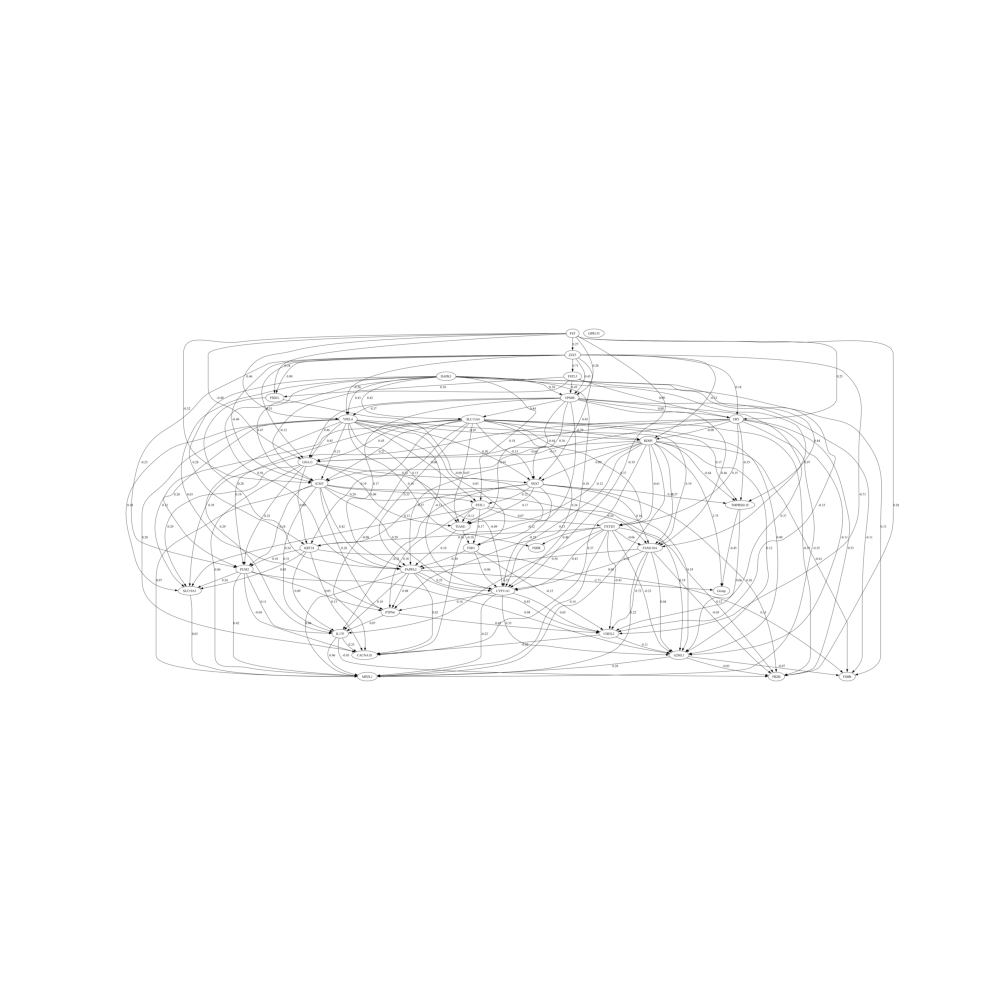

In [ ]:
EstimationModel = EstimateEffect(df)

causal_graph = EstimationModel.find_causal_graph(algo='icalingam')

disp_graph_nx(causal_graph)

In [ ]:
nx.is_directed_acyclic_graph(causal_graph)

True

In [ ]:
EstimationModel.refute_cgm(show_plt=True, n_perm=100)

KeyboardInterrupt: 

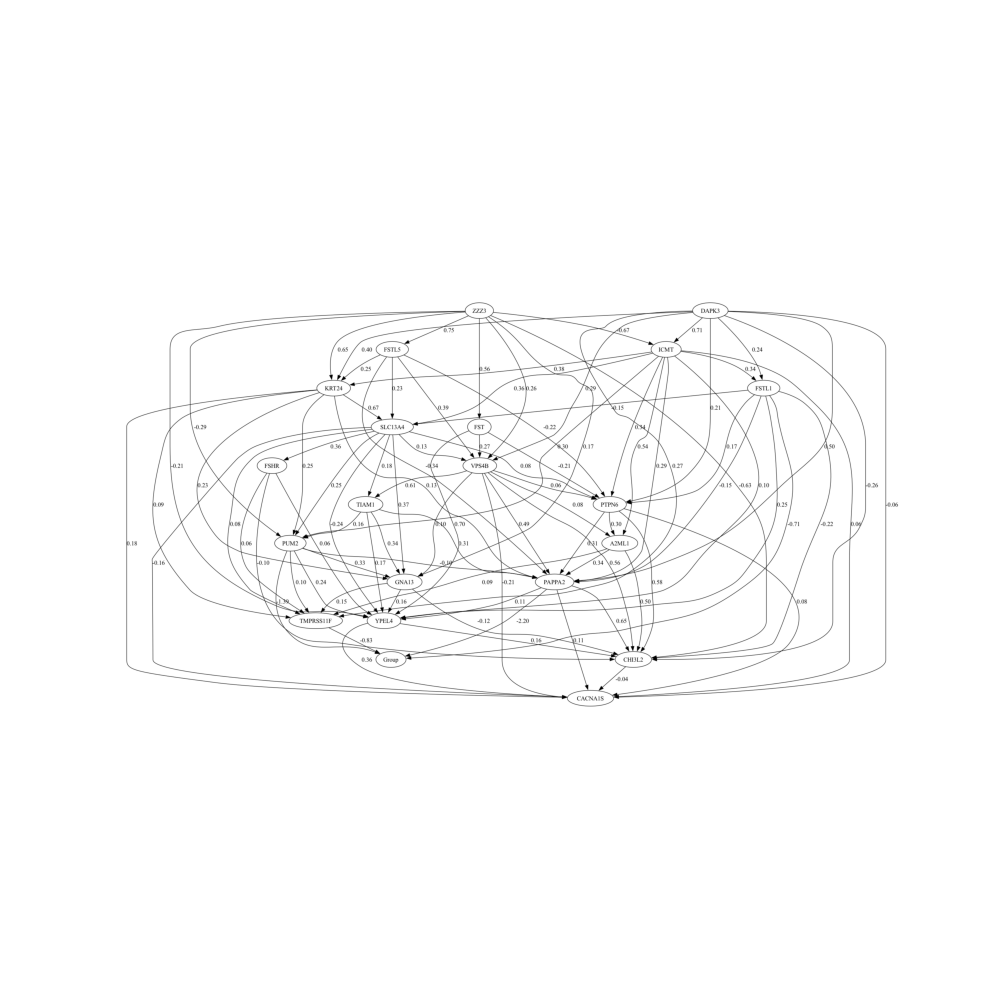

In [ ]:
disp_graph_nx(EstimationModel.graph)

In [ ]:
EstimationModel.create_model(treatment='CACNA1S', outcome='Group')

In [ ]:
print(EstimationModel.identify_effect())

Note that you can also use other methods for the identification process. Below are method descriptions taken directly from DoWhy's documentation
maximal-adjustment: returns the maximal set that satisfies the backdoor criterion. This is usually the fastest way to find a valid backdoor set, but the set may contain many superfluous variables.
minimal-adjustment: returns the set with minimal number of variables that satisfies the backdoor criterion. This may take longer to execute, and sometimes may not return any backdoor set within the maximum number of iterations.
exhaustive-search: returns all valid backdoor sets. This can take a while to run for large graphs.
default: This is a good mix of minimal and maximal adjustment. It starts with maximal adjustment which is usually fast. It then runs minimal adjustment and returns the set having the smallest number of variables.
No directed path from ['CACNA1S'] to ['Group'] in the causal graph.
Causal effect is zero.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
EstimationModel.estimate_effect(ctrl_val=0.2, trtm_val=0.3)

Note that it is ok for your treatment to be a continuous variable, DoWhy automatically discretizes at the backend.


In [ ]:
EstimationModel.refute_estimate(placebo_type="permute")

Error in refuting estimate: 'NoneType' object is not subscriptable


TypeError: 'NoneType' object is not subscriptable

In [ ]:
info = EstimationModel.get_all_information()

In [ ]:
print(info['graph_refutation_res'])

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 0 / 100 of the permutations lie in the Markov                    |
| equivalence class of the given DAG (p-value: 0.00).                                                   |
| The given DAG violates 52/84 LMCs and is better than 100.0% of the permuted DAGs (p-value: 0.00).     |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+


In [ ]:
print(info['estimand_expression'])

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d              
────────(E[Group])
d[GNA₁₃]          
Estimand assumption 1, Unconfoundedness: If U→{GNA13} and U→Group then P(Group|GNA13,,U) = P(Group|GNA13,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡                                            d                               
E⎢────────────────────────────────────────────────────────────────────────────
 ⎣d[SLC13A4  PAPPA₂  CEP₁₁₀  MPZL₁  TIAM₁  C4BPB  TMPRSS11F  IL17F  CYP11A1  S

                         ∂                                                    
──────────────(Group)⋅────────([SLC13A4  PAPPA₂  CEP₁₁₀  MPZL₁  TIAM₁  C4BPB  
LC19A1  DAPK₃]        ∂[GNA₁₃]                                                

                                           ⎤
TMPRSS11F  IL17F  CYP11A1  SLC19A1  DAPK₃])⎥
                                  

In [ ]:
print(info['effect_estimate'].interpret())

Increasing the treatment variable(s) [GNA13] from 0.2 to 0.3 causes an increase of -0.2942679757787924 in the expected value of the outcome [['Group']], over the data distribution/population represented by the dataset.
None


In [ ]:
print(info['estimate_refutation_res'])

Refute: Use a Placebo Treatment
Estimated effect:-0.2942679757787924
New effect:0.004093044250515748
p value:0.8400000000000001



In [ ]:
EstimationModel.graph.edges

OutEdgeView([('FSHR', 'TMPRSS11F'), ('FSHR', 'YPEL4'), ('FSHR', 'CHI3L2'), ('TMPRSS11F', 'Group'), ('YPEL4', 'CHI3L2'), ('YPEL4', 'CACNA1S'), ('CHI3L2', 'CACNA1S'), ('ZZZ3', 'FSTL5'), ('ZZZ3', 'YPEL4'), ('ZZZ3', 'PUM2'), ('ZZZ3', 'KRT24'), ('ZZZ3', 'ICMT'), ('ZZZ3', 'CHI3L2'), ('ZZZ3', 'FST'), ('ZZZ3', 'VPS4B'), ('ZZZ3', 'GNA13'), ('FSTL5', 'PTPN6'), ('FSTL5', 'PAPPA2'), ('FSTL5', 'KRT24'), ('FSTL5', 'SLC13A4'), ('FSTL5', 'VPS4B'), ('PUM2', 'TMPRSS11F'), ('PUM2', 'PAPPA2'), ('PUM2', 'YPEL4'), ('PUM2', 'GNA13'), ('PUM2', 'Group'), ('KRT24', 'TMPRSS11F'), ('KRT24', 'PAPPA2'), ('KRT24', 'PUM2'), ('KRT24', 'SLC13A4'), ('KRT24', 'GNA13'), ('KRT24', 'CACNA1S'), ('ICMT', 'A2ML1'), ('ICMT', 'PTPN6'), ('ICMT', 'FSTL1'), ('ICMT', 'PAPPA2'), ('ICMT', 'YPEL4'), ('ICMT', 'PUM2'), ('ICMT', 'KRT24'), ('ICMT', 'SLC13A4'), ('ICMT', 'CACNA1S'), ('FST', 'PTPN6'), ('FST', 'YPEL4'), ('FST', 'VPS4B'), ('VPS4B', 'A2ML1'), ('VPS4B', 'PTPN6'), ('VPS4B', 'PAPPA2'), ('VPS4B', 'CHI3L2'), ('VPS4B', 'TIAM1'), ('VPS